In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import copy
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import tree
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB,CategoricalNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [2]:
myDF=pd.read_table("Seismic bumps/seismic-bumps.txt",sep=",")
myDF.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [3]:
myDF.dtypes

seismic           object
seismoacoustic    object
shift             object
genergy            int64
gpuls              int64
gdenergy           int64
gdpuls             int64
ghazard           object
nbumps             int64
nbumps2            int64
nbumps3            int64
nbumps4            int64
nbumps5            int64
nbumps6            int64
nbumps7            int64
nbumps89           int64
energy             int64
maxenergy          int64
class              int64
dtype: object

In [4]:
myDF["class"]=myDF["class"].astype('category')
myDF_names_num=myDF.select_dtypes(include=np.number).columns
myDF_names_cat=myDF.select_dtypes(exclude=np.number).columns
myDF[myDF_names_cat]=myDF[myDF_names_cat].astype('category')
myDF.dtypes


seismic           category
seismoacoustic    category
shift             category
genergy              int64
gpuls                int64
gdenergy             int64
gdpuls               int64
ghazard           category
nbumps               int64
nbumps2              int64
nbumps3              int64
nbumps4              int64
nbumps5              int64
nbumps6              int64
nbumps7              int64
nbumps89             int64
energy               int64
maxenergy            int64
class             category
dtype: object

In [5]:
myDF[myDF_names_num].describe()


,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.0,2584.0,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,0.0,0.0,0.0,4975.270898,4278.850619
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,0.0,0.0,0.0,20450.833222,19357.454882
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,2600.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,0.0,0.0,0.0,402000.000000,400000.000000


In [6]:
myDF[myDF_names_cat].describe()

,seismic,seismoacoustic,shift,ghazard,class
count,2584,2584,2584,2584,2584
unique,2,3,2,3,2
top,a,a,W,a,0
freq,1682,1580,1663,2342,2414


In [7]:
myDF=myDF.drop(columns=['nbumps6', 'nbumps7', 'nbumps89'],errors='ignore')
N=myDF.shape[0]
L=myDF.shape[1]
myDF_names_num=myDF.select_dtypes(include=np.number).columns
myDF.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0


In [8]:
for col in myDF_names_cat:
    print(myDF[col].value_counts())

a    1682
b     902
Name: seismic, dtype: int64
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64
W    1663
N     921
Name: shift, dtype: int64
a    2342
b     212
c      30
Name: ghazard, dtype: int64
0    2414
1     170
Name: class, dtype: int64


In [9]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def cramers_v_row(c,m):
    return(np.asarray(m.apply(lambda x: cramers_v(x, c))))

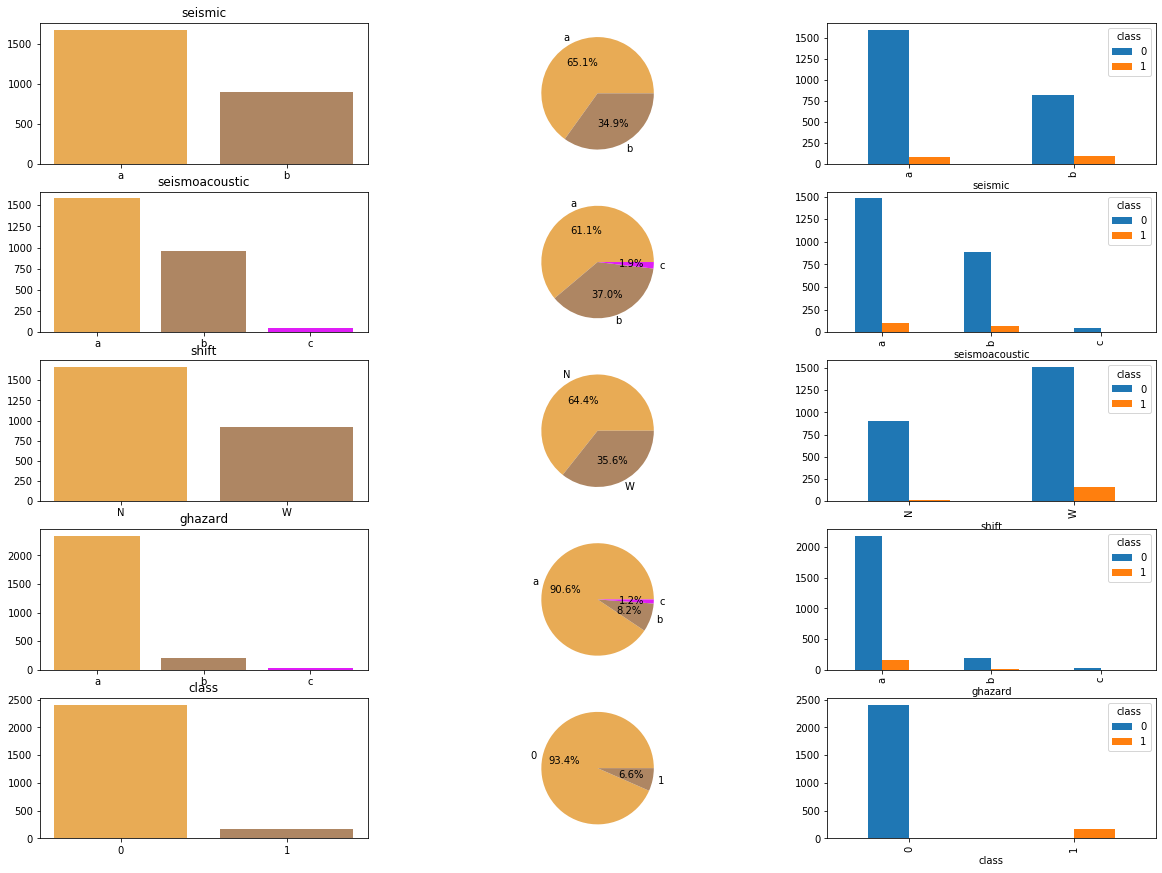

In [10]:
myDF_n_cat=len(myDF_names_cat)
fig, axs = plt.subplots(myDF_n_cat,3,figsize=(20, 15))
bar_col = np.random.rand(20,3)
cramersV_matrix=pd.DataFrame(np.zeros((myDF_n_cat, myDF_n_cat)),columns=myDF_names_cat,index=myDF_names_cat)
for i in range(myDF_n_cat):
    col = myDF_names_cat[i]
    l=myDF[col].unique()
    n=myDF[col].nunique()
    x =  np.arange(n)
    y = myDF[col].value_counts()
    axs[i,0].bar(x,y,color=bar_col[0:n,:])
    axs[i,0].set_title(col)
    axs[i,0].set_xticks(x)
    axs[i,0].set_xticklabels(l)
    axs[i,1].pie(y,labels=l,autopct='%1.1f%%',colors=bar_col[0:n,:])
    pd.crosstab(index=myDF[col], columns=myDF["class"]).plot(kind="bar",ax= axs[i,2])
    cramersV_matrix[col]=cramers_v_row(myDF[col],myDF[myDF_names_cat])


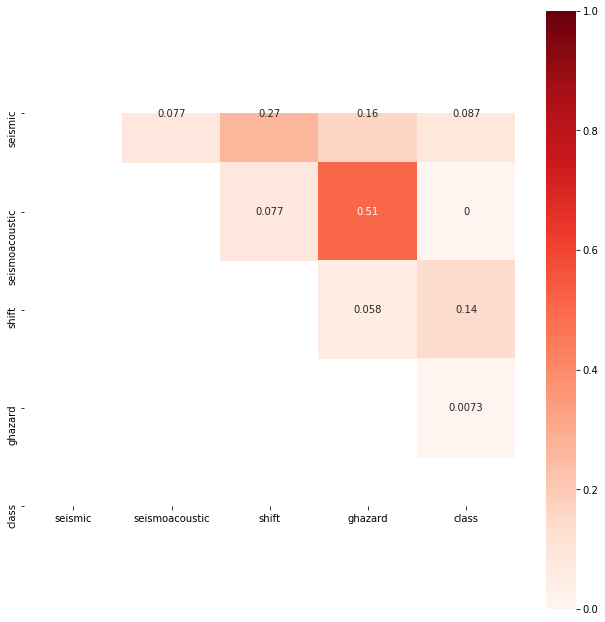

In [11]:
mask = np.tril(np.ones_like(cramersV_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 11))
ax=sns.heatmap(cramersV_matrix, mask=mask, cmap="Reds", vmax=1,square=True,annot=True)

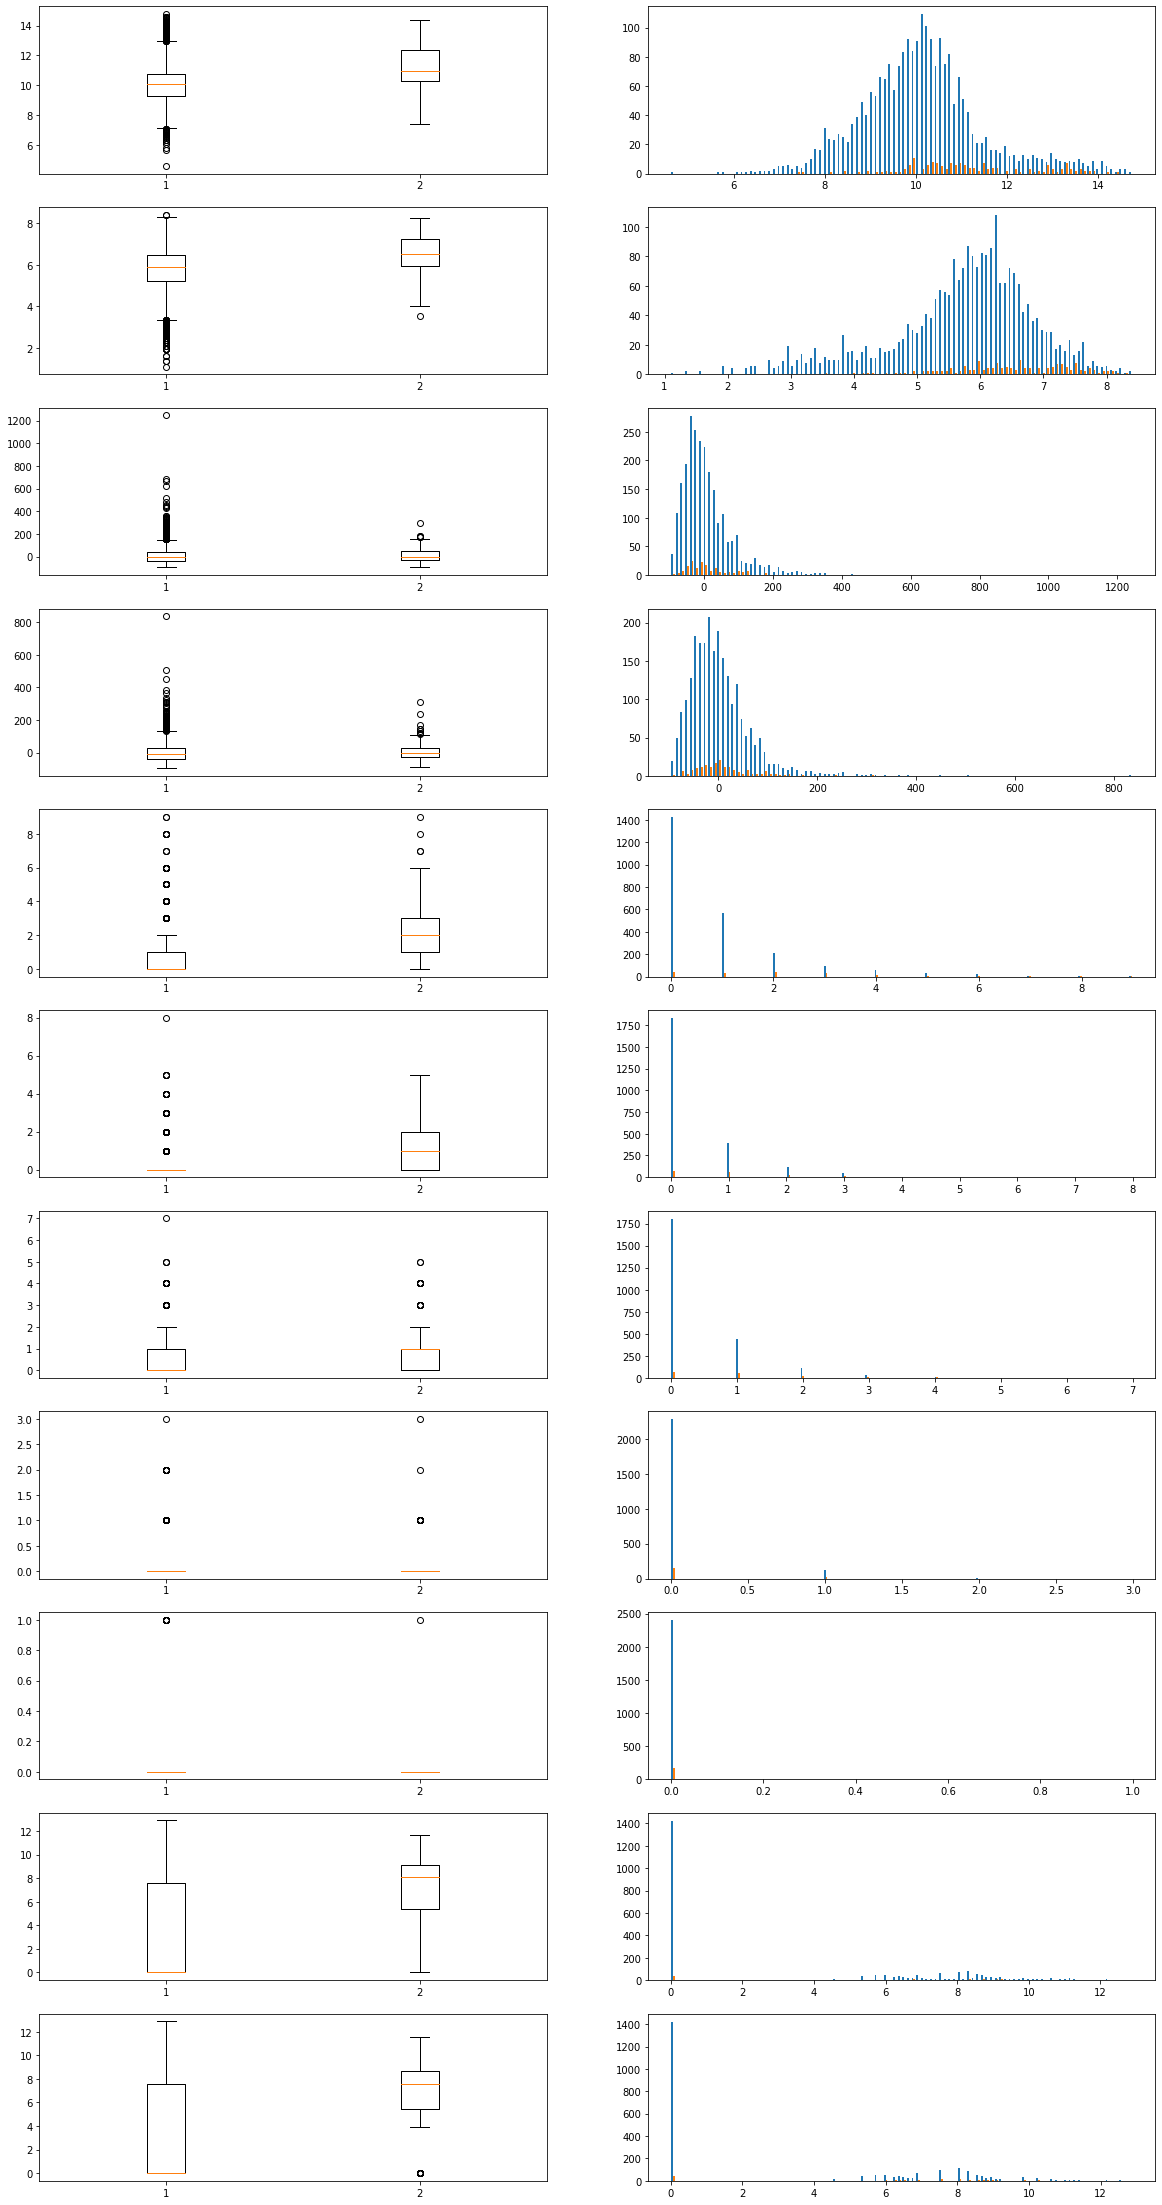

In [12]:
myDF_n_num = len(myDF_names_num)
fig, ax = plt.subplots(myDF_n_num,2,figsize=(20, 40))
for i in range(myDF_n_num):
    if max(myDF[myDF_names_num[i]])<2000:
        toplot =[myDF[myDF_names_num[i]][myDF['class']==0], myDF[myDF_names_num[i]][myDF['class']==1]]
    else:
        toplot  =[np.log(myDF[myDF_names_num[i]][myDF['class']==0]+1),np.log(myDF[myDF_names_num[i]][myDF['class']==1]+1)]
    ax[i,0].boxplot(toplot )
    ax[i,1].hist(toplot,100)


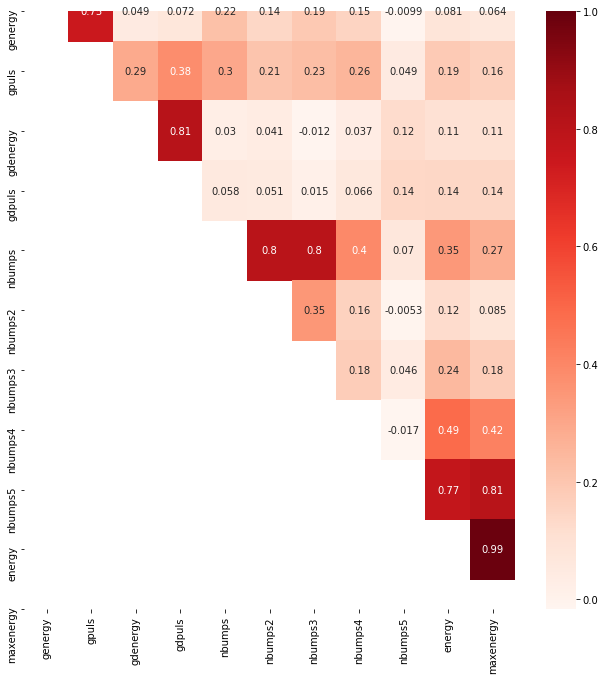

In [13]:
mask = np.tril(np.ones_like(myDF[myDF_names_num].corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 11))
ax=sns.heatmap(myDF[myDF_names_num].corr(),cmap='Reds',mask=mask,annot=True)

In [14]:
def myscale(X):
    return(X*1.0/(X.max()- X.min()))

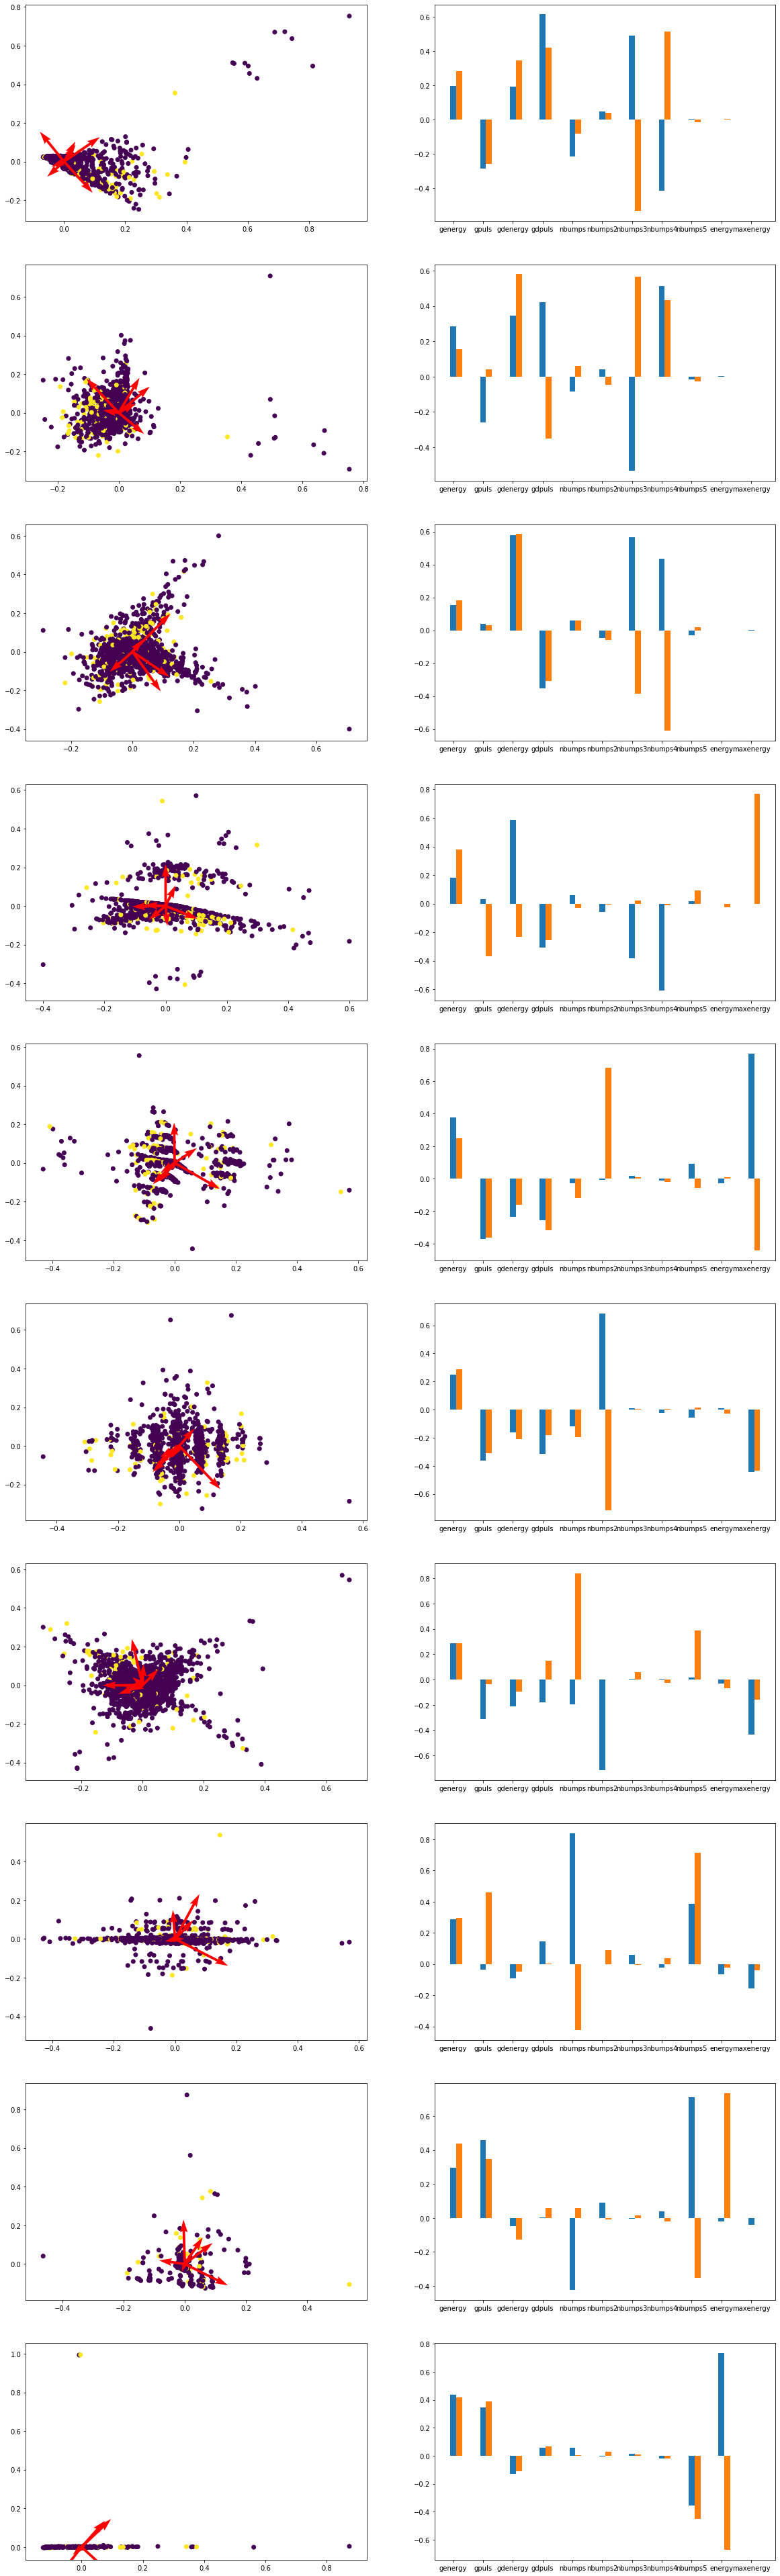

In [15]:
myDF_norm=sk.preprocessing.scale(myDF[myDF_names_num])
pca = sk.decomposition.PCA()
scores=pca.fit_transform(myDF_norm)
pca.__dict__
fig, ax = plt.subplots(myDF_n_num-1,2,figsize=(20, 70))
for i in range(myDF_n_num-1):
    ax[i,0].scatter(myscale(scores[:,i]),myscale(scores[:,i+1]),c=myDF['class'])
    ax[i,0].quiver(0, 0, pca.components_[:,i], pca.components_[:,i+1],color='r',alpha=1)
    ax[i,1].bar(np.arange(myDF_n_num),pca.components_[:,i],width=0.2)
    ax[i,1].bar(np.arange(myDF_n_num)+.2,pca.components_[:,i+1],width=0.2)
    ax[i,1].set_xticks(np.arange(myDF_n_num))
    ax[i,1].set_xticklabels(myDF_names_num)

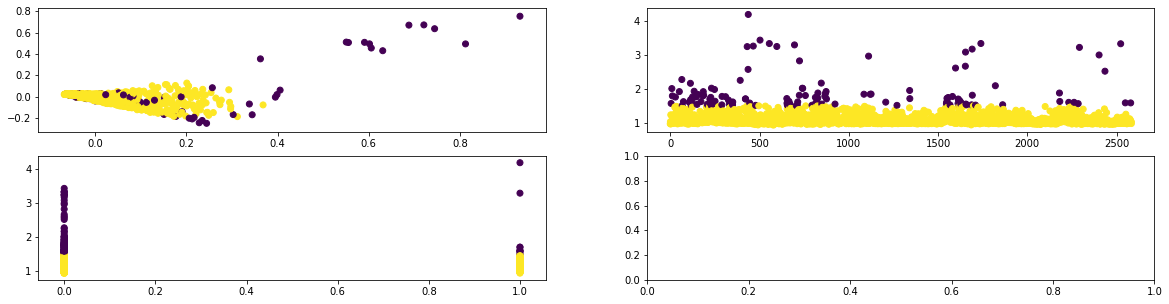

In [16]:
lof=LocalOutlierFactor()
lof.fit(myDF_norm)
lof.fit_predict(myDF_norm)
f, ax = plt.subplots(2,2,figsize=(20, 5))
ax[0,0].scatter(myscale(scores[:,0]),myscale(scores[:,1]),c=lof.fit_predict(myDF_norm))
ax[0,1].scatter(np.arange(N),-lof.negative_outlier_factor_,c=lof.fit_predict(myDF_norm))
ax[1,0].scatter(myDF['class'],-lof.negative_outlier_factor_,c=lof.fit_predict(myDF_norm))

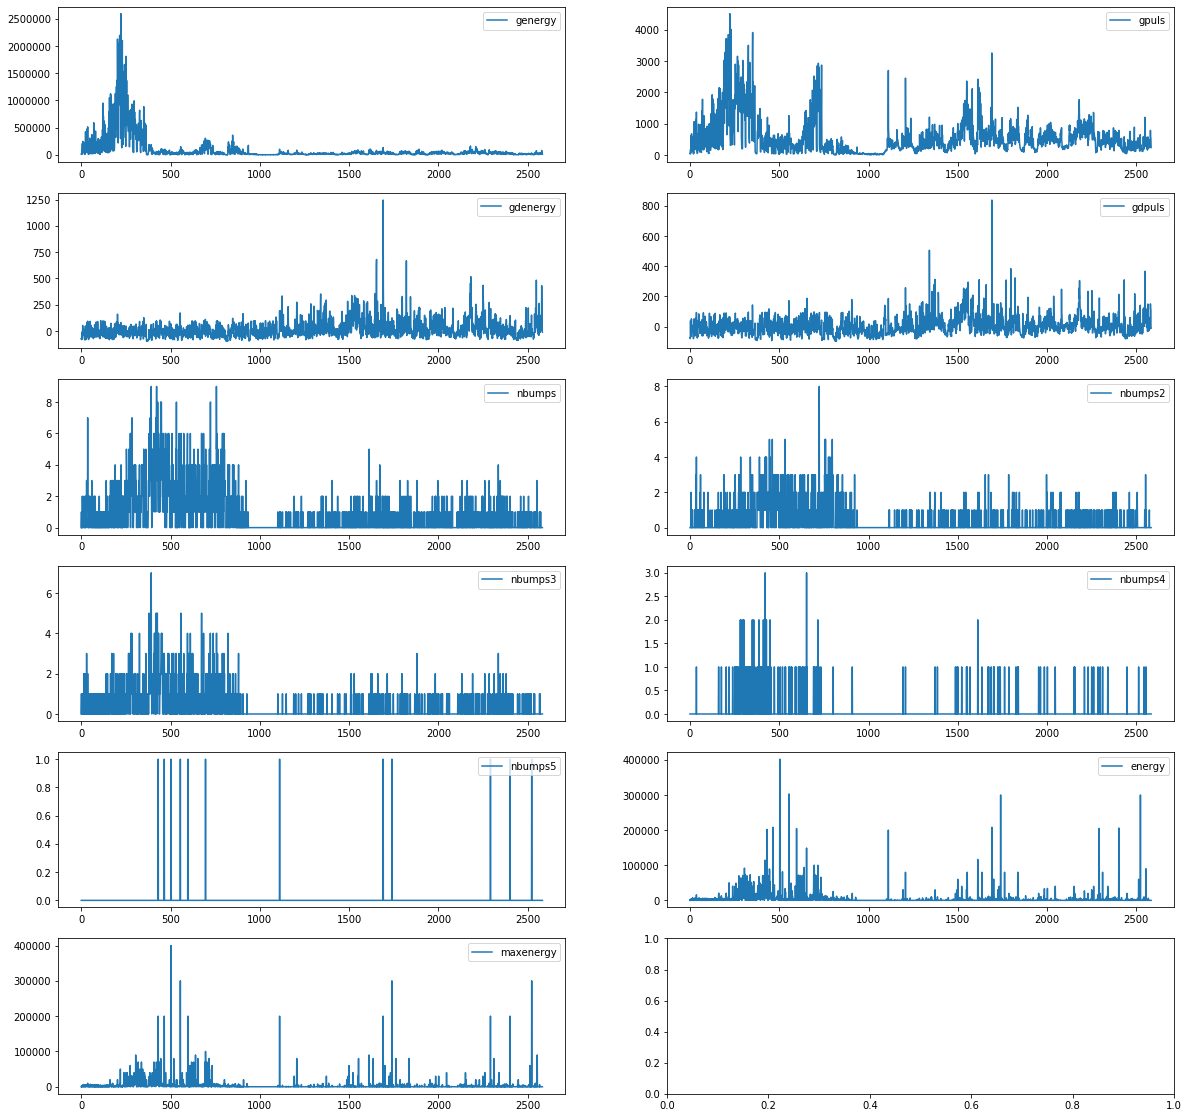

In [17]:
f, ax = plt.subplots((myDF_n_num+1)//2,2,figsize=(20, 20))
for i in range(myDF_n_num):
    col = myDF_names_num[i]
    ax[i//2,i%2].plot(np.arange(N),myDF[col],label=col)
    ax[i//2,i%2].legend(loc="upper right")

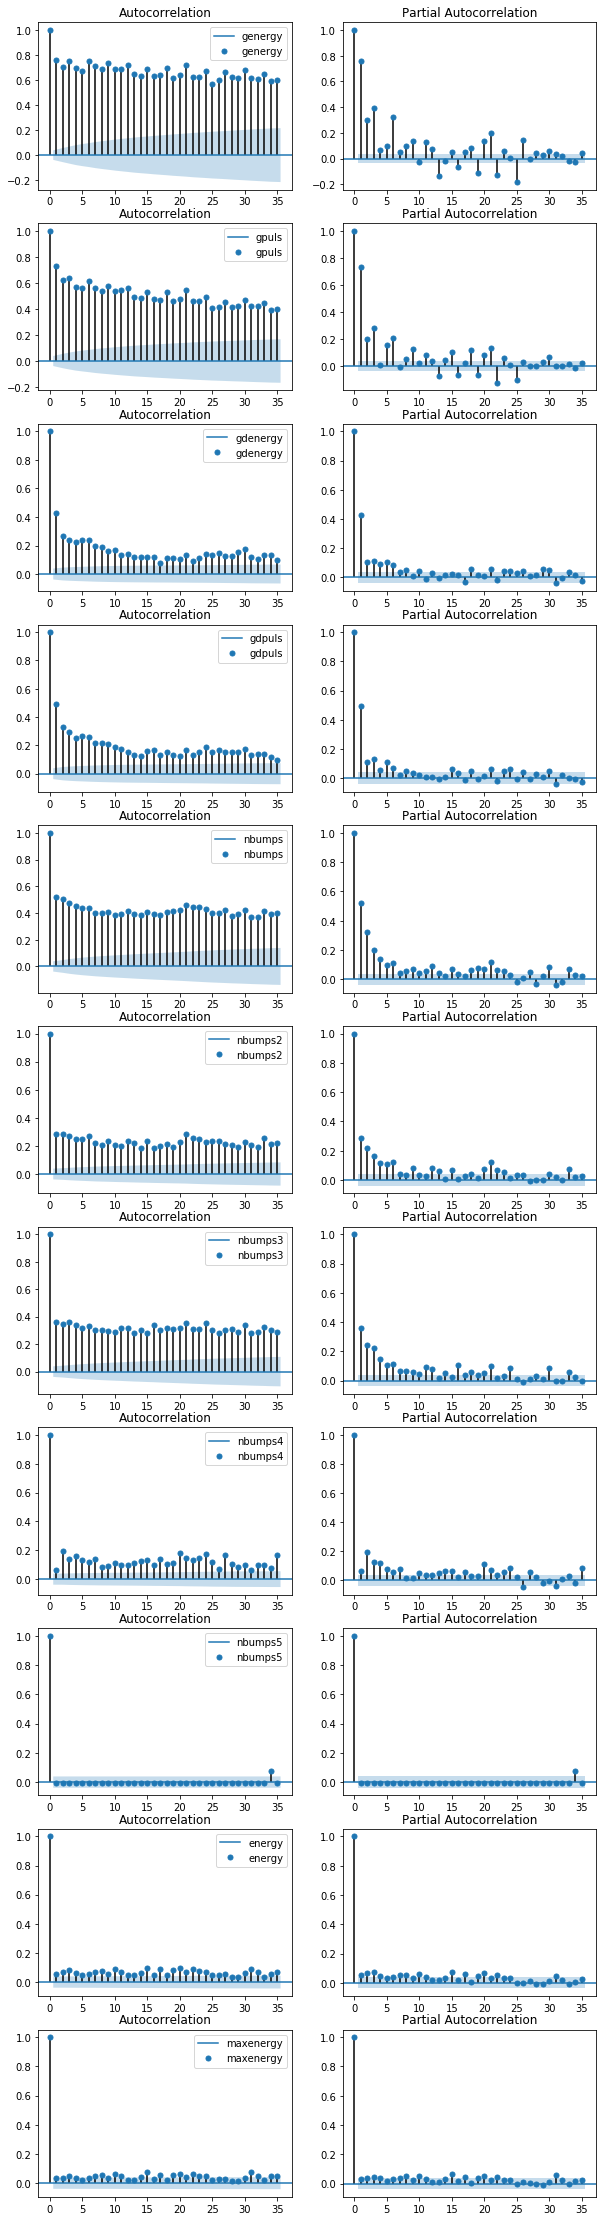

In [18]:
f, ax = plt.subplots(myDF_n_num,2,figsize=(10, 40))
for i in range(myDF_n_num):
    col = myDF_names_num[i]
    plot_acf(myDF[col],ax=ax[i,0],label=col)
    plot_pacf(myDF[col],ax=ax[i,1])
    ax[i,0].legend(loc="upper right")

In [19]:
myDFdummies=pd.get_dummies(data= myDF.loc[:, myDF.columns != 'class'],columns=myDF_names_cat[myDF_names_cat!= 'class'],drop_first=True)
myDFdummies


,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c
0,15180,48,-72,-72,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14720,33,-70,-79,1,0,1,0,0,2000,2000,0,0,0,0,0,0
2,8050,30,-81,-78,0,0,0,0,0,0,0,0,0,0,0,0,0
3,28820,171,-23,40,1,0,1,0,0,3000,3000,0,0,0,0,0,0
4,12640,57,-63,-52,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,81410,785,432,151,0,0,0,0,0,0,0,1,0,0,1,1,0
2580,42110,555,213,118,0,0,0,0,0,0,0,1,0,0,1,0,0
2581,26960,540,101,112,0,0,0,0,0,0,0,1,0,0,1,0,0
2582,16130,322,2,2,0,0,0,0,0,0,0,0,0,0,1,0,0


[[2152  262]
 [ 141   29]]
[0.8914664457332229, 0.17058823529411765]
[0.8456765735835503, 0.5070851421057144, 0.5237134811402013, 0.07655780268559173, 0.15294117647058825]
[[2264  150]
 [ 136   34]]
[0.9378624689312345, 0.2]
[0.8894196522103499, 0.5279554518648606, 0.5690048352251293, 0.11020468998410175, 0.2]
[[2365   49]
 [ 164    6]]
[0.97970173985087, 0.03529411764705882]
[0.9179940738080274, 0.48901201128719257, 0.5159333981526495, 0.0416008316008316, 0.052941176470588235]
[[2059  355]
 [ 136   34]]
[0.8529411764705882, 0.2]
[0.9168357726497263, 0.48012372783426843, 0.5071098687408847, 0.025, 0.03529411764705882]


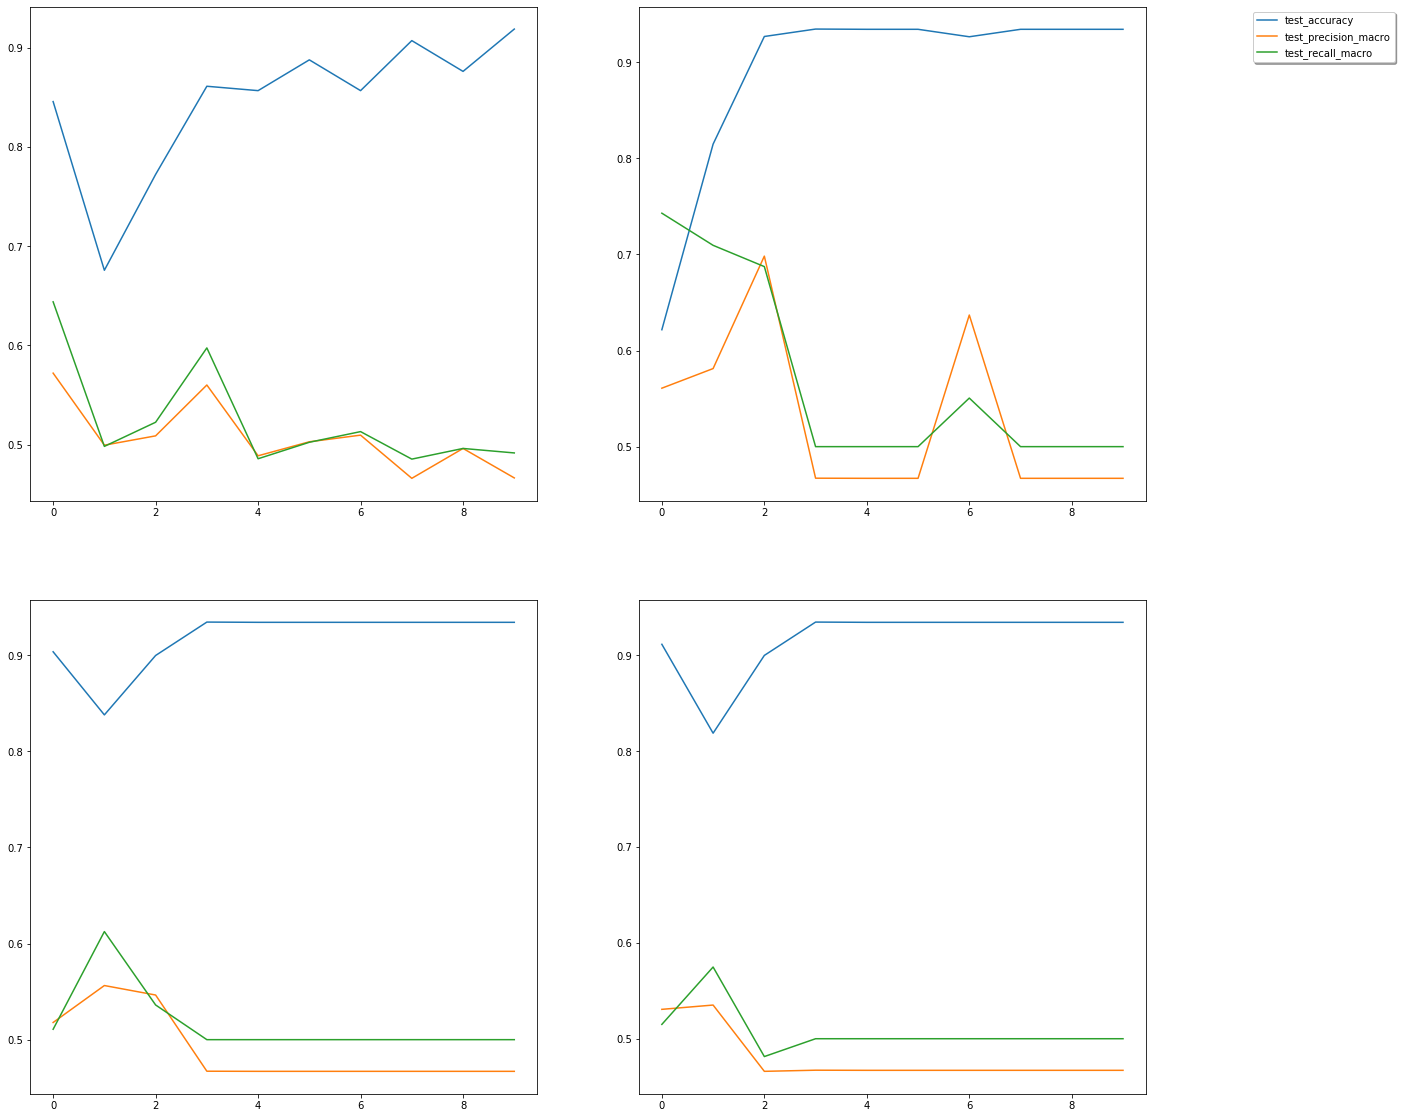

In [20]:
DT=tree.DecisionTreeClassifier()
NB=GaussianNB()
RF=RandomForestClassifier()
MLP=MLPClassifier()
DTcv=cross_validate(DT, myDFdummies,myDF['class'], cv=10, scoring=["accuracy",'precision','recall','precision_macro', 'recall_macro'])
NBcv=cross_validate(NB, myDFdummies,myDF['class'], cv=10, scoring=["accuracy",'precision','recall','precision_macro', 'recall_macro'])
RFcv=cross_validate(RF, myDFdummies,myDF['class'], cv=10, scoring=["accuracy",'precision','recall','precision_macro', 'recall_macro'])
MLPcv=cross_validate(RF, myDFdummies,myDF['class'], cv=10, scoring=["accuracy",'precision','recall','precision_macro', 'recall_macro'])
f, ax = plt.subplots(2,2,figsize=(20, 20))
ax[0,0].plot(np.arange(10),DTcv['test_accuracy'],label='test_accuracy')
ax[0,0].plot(np.arange(10),DTcv['test_precision_macro'],label='test_precision_macro')
ax[0,0].plot(np.arange(10),DTcv['test_recall_macro'],label='test_recall_macro')
ax[0,1].plot(np.arange(10),NBcv['test_accuracy'],label='test_accuracy')
ax[0,1].plot(np.arange(10),NBcv['test_precision_macro'],label='test_precision_macro')
ax[0,1].plot(np.arange(10),NBcv['test_recall_macro'],label='test_recall_macro')
ax[1,0].plot(np.arange(10),RFcv['test_accuracy'],label='test_accuracy')
ax[1,0].plot(np.arange(10),RFcv['test_precision_macro'],label='test_precision_macro')
ax[1,0].plot(np.arange(10),RFcv['test_recall_macro'],label='test_recall_macro')
ax[1,1].plot(np.arange(10),MLPcv['test_accuracy'],label='test_accuracy')
ax[1,1].plot(np.arange(10),MLPcv['test_precision_macro'],label='test_precision_macro')
ax[1,1].plot(np.arange(10),MLPcv['test_recall_macro'],label='test_recall_macro')
ax[0,1].legend(loc="upper right", bbox_to_anchor=(1.5, 1), ncol=1,  fancybox=True, shadow=True)
DTcm=confusion_matrix(myDF['class'], cross_val_predict(DT, myDFdummies,myDF['class'], cv=10))
NBcm=confusion_matrix(myDF['class'], cross_val_predict(NB, myDFdummies,myDF['class'], cv=10))
RFcm=confusion_matrix(myDF['class'], cross_val_predict(RF, myDFdummies,myDF['class'], cv=10))
MLPcm=confusion_matrix(myDF['class'], cross_val_predict(MLP, myDFdummies,myDF['class'], cv=10))
print(DTcm)
print([DTcm[0,0]/(DTcm[0,1]+DTcm[0,0]),DTcm[1,1]/(DTcm[1,1]+DTcm[1,0])])
print([DTcv['test_accuracy'].mean(),DTcv['test_precision_macro'].mean(),DTcv['test_recall_macro'].mean(),DTcv['test_precision'].mean(),DTcv['test_recall'].mean()])
print(NBcm)
print([NBcm[0,0]/(NBcm[0,1]+NBcm[0,0]),NBcm[1,1]/(NBcm[1,1]+NBcm[1,0])])
print([NBcv['test_accuracy'].mean(),NBcv['test_precision_macro'].mean(),NBcv['test_recall_macro'].mean(),NBcv['test_precision'].mean(),NBcv['test_recall'].mean()])
print(RFcm)
print([RFcm[0,0]/(RFcm[0,1]+RFcm[0,0]),RFcm[1,1]/(RFcm[1,1]+RFcm[1,0])])
print([RFcv['test_accuracy'].mean(),RFcv['test_precision_macro'].mean(),RFcv['test_recall_macro'].mean(),RFcv['test_precision'].mean(),RFcv['test_recall'].mean()])
print(MLPcm)
print([MLPcm[0,0]/(MLPcm[0,1]+MLPcm[0,0]),MLPcm[1,1]/(MLPcm[1,1]+MLPcm[1,0])])
print([MLPcv['test_accuracy'].mean(),MLPcv['test_precision_macro'].mean(),MLPcv['test_recall_macro'].mean(),MLPcv['test_precision'].mean(),MLPcv['test_recall'].mean()])


In [21]:
from sklearn.base import clone


class MetaCost(object):

    """A procedure for making error-based classifiers cost-sensitive
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.linear_model import LogisticRegression
    >>> import pandas as pd
    >>> import numpy as np
    >>> S = pd.DataFrame(load_iris().data)
    >>> S['target'] = load_iris().target
    >>> LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    >>> C = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    >>> model = MetaCost(S, LR, C).fit('target', 3)
    >>> model.predict_proba(load_iris().data[[2]])
    >>> model.score(S[[0, 1, 2, 3]].values, S['target'])
    .. note:: The form of the cost matrix C must be as follows:
    +---------------+----------+----------+----------+
    |  actual class |          |          |          |
    +               |          |          |          |
    |   +           | y(x)=j_1 | y(x)=j_2 | y(x)=j_3 |
    |       +       |          |          |          |
    |           +   |          |          |          |
    |predicted class|          |          |          |
    +---------------+----------+----------+----------+
    |   h(x)=j_1    |    0     |    a     |     b    |
    |   h(x)=j_2    |    c     |    0     |     d    |
    |   h(x)=j_3    |    e     |    f     |     0    |
    +---------------+----------+----------+----------+
    | C = np.array([[0, a, b],[c, 0 , d],[e, f, 0]]) |
    +------------------------------------------------+
    """
    def __init__(self, S, L, C, m=50, n=1, p=True, q=True):
        """
        :param S: The training set
        :param L: A classification learning algorithm
        :param C: A cost matrix
        :param q: Is True iff all resamples are to be used  for each examples
        :param m: The number of resamples to generate
        :param n: The number of examples in each resample
        :param p: Is True iff L produces class probabilities
        """
        if not isinstance(S, pd.DataFrame):
            raise ValueError('S must be a DataFrame object')
        new_index = list(range(len(S)))
        S.index = new_index
        self.S = S
        self.L = L
        self.C = C
        self.m = m
        self.n = len(S) * n
        self.p = p
        self.q = q

    def fit(self, flag, num_class):
        """
        :param flag: The name of classification labels
        :param num_class: The number of classes
        :return: Classifier
        """
        col = [col for col in self.S.columns if col != flag]
        S_ = {}
        M = []

        for i in range(self.m):
            # Let S_[i] be a resample of S with self.n examples
            S_[i] = self.S.sample(n=self.n, replace=True)

            X = S_[i][col].values
            y = S_[i][flag].values

            # Let M[i] = model produced by applying L to S_[i]
            model = clone(self.L)
            M.append(model.fit(X, y))

        label = []
        S_array = self.S[col].values
        for i in range(len(self.S)):
            if not self.q:
                k_th = [k for k, v in S_.items() if i not in v.index]
                M_ = list(np.array(M)[k_th])
            else:
                M_ = M

            if self.p:
                P_j = [model.predict_proba(S_array[[i]]) for model in M_]
            else:
                P_j = []
                vector = [0] * num_class
                for model in M_:
                    vector[model.predict(S_array[[i]])] = 1
                    P_j.append(vector)

            # Calculate P(j|x)
            P = np.array(np.mean(P_j, 0)).T

            # Relabel
            label.append(np.argmin(self.C.dot(P)))

        # Model produced by applying L to S with relabeled y
        X_train = self.S[col].values
        y_train = np.array(label)
        model_new = clone(self.L)
        model_new.fit(X_train, y_train)

        return model_new

    

In [71]:
def lagg(X,n):
    Y=copy.copy(X)
    for i in range(1,n+1):
        Y=pd.merge(Y,X.shift(i),how='inner',suffixes=('', "-" +str(i)),left_index=True, right_index=True)
    return(Y)

def myCV_eval(model,predictors,target,F=10):
    myCVscores=cross_validate(model, predictors,target, cv=F, scoring=["accuracy",'f1_macro','roc_auc','precision_macro', 'recall_macro'])
    toreturn={'accuracy': round(myCVscores['test_accuracy'].mean()*100,2),
              'test_f1_macro': round(myCVscores['test_f1_macro'].mean(),3),
              'test_roc_auc': round(myCVscores['test_roc_auc'].mean(),3),
             'test_precision_macro': round(myCVscores['test_precision_macro'].mean()*100,2),
              'test_recall_macro': round(myCVscores['test_recall_macro'].mean()*100,2)}
    return(toreturn)

def myCV_cm(model,predictors,target,F=10):
    cm=confusion_matrix(target, cross_val_predict(model, predictors,target, cv=F))
    return(cm)

def myCV(model,predictors,target,F=10):
    cv = StratifiedKFold(n_splits=F)
    i=0
    target_test=copy.copy(target)
    m=pd.DataFrame(np.zeros((F,5)),columns=['accuracy','f1_macro','roc_auc','precision_macro', 'recall_macro'])
    for train_idx, test_idx, in cv.split(predictors, target):
        X_train, y_train = predictors.iloc[train_idx,:], target.iloc[train_idx]
        X_test, y_test = predictors.iloc[test_idx,:], target.iloc[test_idx]
        model.fit(X_train, y_train)  
        y_pred = model.predict(X_test)
        target_test.iloc[test_idx]=y_pred
        m.iloc[i,:]=[model.score(X_test, y_test),
                     f1_score(y_test, y_pred, average='macro'),
                     roc_auc_score(y_test, y_pred, average='macro'),
                     precision_score(y_test, y_pred, average='macro'),
                     recall_score(y_test, y_pred, average='macro')]
        i+=1
    CM=confusion_matrix(target,target_test)
    toreturn={'accuracy': round(m['accuracy'].mean()*100,2),
              'f1_macro': round(m['f1_macro'].mean(),3),
              'roc_auc': round(m['roc_auc'].mean(),3),
             'precision_macro': round(m['precision_macro'].mean()*100,2),
              'recall_macro': round(m['recall_macro'].mean()*100,2),
             'sensitivity':  round(100*CM[1,1]/(CM[1,1]+CM[1,0]),2),
             'specificity': round(100*CM[0,0]/(CM[0,1]+CM[0,0]),2)}
    return(toreturn)

def myMetacostCV(model,predictors,target,C,F=10):
    S=pd.merge(predictors,target,how='inner', left_index=True, right_index=True)
    target_test=copy.copy(target)
    cv = StratifiedKFold(n_splits=F)
    i=0
    m=pd.DataFrame(np.zeros((F,5)),columns=['accuracy','f1_macro','roc_auc','precision_macro', 'recall_macro'])
    for train_idx, test_idx, in cv.split(predictors, target):
        X_train, y_train = predictors.iloc[train_idx,:], target.iloc[train_idx]
        X_test, y_test = predictors.iloc[test_idx,:], target.iloc[test_idx]
        iMetacost=MetaCost(S.iloc[train_idx,:], model, C)
        model2=iMetacost.fit('class',2)  
        y_pred = model2.predict(X_test)
        target_test.iloc[test_idx]=y_pred
        m.iloc[i,:]=[model2.score(X_test, y_test),
                     f1_score(y_test, y_pred, average='macro'),
                     roc_auc_score(y_test, y_pred, average='macro'),
                     precision_score(y_test, y_pred, average='macro'),
                     recall_score(y_test, y_pred, average='macro')]
        i+=1
    CM=confusion_matrix(target,target_test)
    toreturn={'accuracy': round(m['accuracy'].mean()*100,2),
              'f1_macro': round(m['f1_macro'].mean(),3),
              'roc_auc': round(m['roc_auc'].mean(),3),
             'precision_macro': round(m['precision_macro'].mean()*100,2),
              'recall_macro': round(m['recall_macro'].mean()*100,2),
             'sensitivity':  round(100*CM[1,1]/(CM[1,1]+CM[1,0]),2),
             'specificity': round(100*CM[0,0]/(CM[0,1]+CM[0,0]),2)}
    return(toreturn)

def forward_selection(model,predictors, target):
    initial_features = predictors.columns.tolist()
    best_features = []
    auc_best=0
    best_score=[]
    while (len(list(initial_features))>0):
        remaining_features = list(set(initial_features)-set(best_features))
        auc_temp = 0
        temp_score=[]
        for new_column in remaining_features:
            score=myCV(model,pd.DataFrame(predictors[[new_column] + best_features]),target,F=10)
            new_auc=score['recall_macro']
            if(new_auc>auc_temp):
                auc_temp=new_auc
                new_feature=new_column
                temp_score=score
        if(auc_temp>auc_best):
            auc_best=auc_temp
            best_features.append(new_feature)
            best_score=temp_score
            print(best_features)
            print(best_score)
        else:
            break
    return(best_features,best_score)

def forward_selection_metacost(model,predictors, target,C):
    initial_features = predictors.columns.tolist()
    best_features = []
    auc_best=0
    best_score=[]
    while (len(list(initial_features))>0):
        remaining_features = list(set(initial_features)-set(best_features))
        auc_temp = 0
        temp_score=[]
        for new_column in remaining_features:
            print(new_column)
            score=myMetacostCV(model,pd.DataFrame(predictors[[new_column] + best_features]),target,C,F=10)
            new_auc=score['recall_macro']
            if(new_auc>auc_temp):
                auc_temp=new_auc
                new_feature=new_column
                temp_score=score
        if(auc_temp>auc_best):
            auc_best=auc_temp
            best_features.append(new_feature)
            best_score=temp_score
            print(best_features)
            print(best_score)
        else:
            break
    return(best_features,best_score)

In [59]:
lg=15
newDF=copy.deepcopy(myDFdummies)
newDF.iloc[:,:]=sk.preprocessing.scale(newDF)
newDF=lagg(newDF,lg)
pca2 = sk.decomposition.PCA(n_components=0.7)
PCA_matrix=pca2.fit_transform(newDF.iloc[lg:,:])
newDF_PCA=pd.DataFrame(PCA_matrix,index=range(lg,N),columns=['PC' + str(s+1) for s in range(PCA_matrix.shape[1])])
newDF_class=pd.DataFrame(myDF['class'][lg:])
cumsumPCA=np.cumsum(pca2.explained_variance_ratio_)
len(cumsumPCA)
newDF_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39
15,-3.573472,-2.689132,3.701259,0.868584,-0.242593,1.238543,-1.206212,-0.318758,1.463102,0.712939,...,1.035281,1.174547,-0.730406,-0.603249,-0.313686,0.846547,0.029895,-0.657355,-1.139737,0.357732
16,-3.478860,-2.532476,3.376973,0.798008,-0.595085,0.970464,-0.855234,-0.074145,1.558337,0.681458,...,0.682198,-0.060432,-1.167629,0.596758,1.159847,-0.600449,-1.382529,0.284352,-0.239057,0.360761
17,-3.584092,-2.300562,3.007933,0.872377,-0.911647,0.586161,-0.510692,0.212659,1.730617,0.496129,...,0.250684,-1.356777,-0.814836,0.189015,0.993723,-1.040732,1.418136,-0.167067,0.051310,0.298635
18,-3.537076,-2.171675,2.740289,0.808954,-1.339797,0.013912,-0.120473,0.484638,1.620470,0.390428,...,0.220264,-1.338194,0.460798,-1.291947,-0.107045,1.190655,-0.022363,-0.668502,0.118410,-0.394457
19,-3.785330,-2.152794,2.550167,0.850814,-1.718950,-0.434315,0.080983,0.675390,1.950577,-0.132424,...,0.170115,-0.639512,1.668798,0.694861,1.146687,0.271967,-1.350010,0.102629,0.372157,-0.683245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,-0.975837,2.008011,-3.273501,-0.514536,7.203930,0.877788,-0.263001,0.422290,-1.500871,-0.444082,...,-0.994910,2.085754,0.866809,-1.052481,-2.212350,-0.375578,-0.127545,0.531943,1.710866,1.523568
2580,-0.856192,2.226425,-3.553099,-0.446193,7.319928,1.433386,-0.348533,0.138873,-1.525067,-0.074125,...,-1.211478,2.693372,-0.044450,0.642401,-1.827278,-0.523224,-1.183907,0.301792,2.829016,1.043259
2581,-0.874678,2.010329,-3.490409,-0.472900,7.322061,1.946839,-0.584568,0.016972,-0.960923,0.024316,...,-1.371904,0.729428,-1.330210,2.383722,-1.526954,0.116390,0.906771,-1.108905,0.278537,1.199651
2582,-1.009356,1.942373,-3.294534,-0.399853,6.959347,1.899531,-0.259105,0.273368,-0.486199,0.197402,...,-1.121336,-1.927664,-1.750397,0.400585,-1.339901,1.146515,-1.006624,-1.047983,-1.804511,1.438041


In [ ]:
{'DT': [myCV_eval(DT,myDFdummies,myDF['class']), myCV_eval(DT,newDF_PCA,newDF_class)],
'RF': [myCV_eval(RF,myDFdummies,myDF['class']), myCV_eval(RF,newDF_PCA,newDF_class)],
'NB': [myCV_eval(NB,myDFdummies,myDF['class']), myCV_eval(NB,newDF_PCA,newDF_class)],
'MLP': [myCV_eval(MLP,myDFdummies,myDF['class']), myCV_eval(MLP,newDF_PCA,newDF_class)],}

In [ ]:
myCV_eval(NB,newDF_PCA,newDF_class)

In [ ]:
myCV(NB,newDF_PCA,newDF_class)

In [ ]:
myMetacostCV(NB,myDFdummies,myDF['class'],np.array([[0, 20], [1, 0]]),10)

In [ ]:
myMetacostCV(NB,newDF_PCA,newDF_class,np.array([[0, 20], [1, 0]]),10)

In [ ]:
FS,BestScore=forward_selection(NB,newDF_PCA,newDF_class)
print(FS)
print(BestScore)

In [72]:
FS,BestScore=forward_selection_metacost(NB,newDF_PCA,newDF_class,np.array([[0, 20], [1, 0]]))
print(FS)
print(BestScore)

PC37
          PC37
268   0.226284
269  -0.168914
270   0.781254
271  -0.248620
272  -0.213297
...        ...
2579  0.531943
2580  0.301792
2581 -1.108905
2582 -1.047983
2583  1.133418

[2312 rows x 1 columns]
          PC37
15   -0.657355
16    0.284352
17   -0.167067
18   -0.668502
19    0.102629
...        ...
2579  0.531943
2580  0.301792
2581 -1.108905
2582 -1.047983
2583  1.133418

[2312 rows x 1 columns]
          PC37
15   -0.657355
16    0.284352
17   -0.167067
18   -0.668502
19    0.102629
...        ...
2579  0.531943
2580  0.301792
2581 -1.108905
2582 -1.047983
2583  1.133418

[2312 rows x 1 columns]
          PC37
15   -0.657355
16    0.284352
17   -0.167067
18   -0.668502
19    0.102629
...        ...
2579  0.531943
2580  0.301792
2581 -1.108905
2582 -1.047983
2583  1.133418

[2312 rows x 1 columns]
          PC37
15   -0.657355
16    0.284352
17   -0.167067
18   -0.668502
19    0.102629
...        ...
2579  0.531943
2580  0.301792
2581 -1.108905
2582 -1.047983
2583  1.13

PC39
          PC39
268   0.435769
269  -0.196324
270  -0.943837
271  -1.202119
272  -1.991693
...        ...
2579  1.523568
2580  1.043259
2581  1.199651
2582  1.438041
2583  1.543106

[2312 rows x 1 columns]


KeyboardInterrupt: 

In [24]:
from scipy.stats import entropy
def binner(DF,pred,target,l):
    DF=DF.sort_values(by=pred)
    L=len(DF[target])
    S=entropy(DF[target].value_counts()/L,base=2)
    MGain=0
    anything=0
    for i in range(L-1):
        a=DF[pred].iloc[i]
        b=DF[pred].iloc[i+1]
        if(a!=b):
            breakpoint=(a+b)/2
            setA=DF.iloc[:i+1]
            setB=DF.iloc[i+1:]
            sA=entropy(setA[target].value_counts()/L,base=2)
            sB=entropy(setB[target].value_counts()/L,base=2)
            newS=len(setA)*sA/L+len(setB)*sB/L
            Gain=S-newS
            if(Gain>MGain):
                MGain=Gain
                splitA=setA
                splitB=setB
                anything=1
                newbreakpoint=breakpoint
                newA=a
                newB=b
    if(anything==1):
        anything=0
        l.append(newbreakpoint)
        if(len(l)<5):
            if(len(splitA)>1):
                binner(copy.copy(splitA),pred,target,l)
                anything=0
            if(len(splitA)>1):   
                binner(copy.copy(splitB),pred,target,l)
                anything=0
    return(l)

In [60]:
forBinning=pd.merge(newDF_PCA,newDF_class,how='inner', left_index=True, right_index=True)
forBinning=forBinning.astype('object')
for col in newDF_PCA.columns:
    print(col)
    bins=binner(forBinning,col,'class',l=[])
    bins.sort()
    print(bins)
    B=len(bins)
    cond=newDF_PCA[col]<bins[0]
    forBinning[col][cond]='<' + str(round(bins[0],2))
    cond=newDF_PCA[col]>=bins[B-1]
    forBinning[col][cond]='>' + str(round(bins[B-1],2))
    for j in range(1,B):
        cond=np.logical_and(newDF_PCA[col]>bins[j-1], newDF_PCA[col]<bins[j])
        forBinning[col][cond]='<' + str(round(bins[j],2))
forBinning=forBinning[forBinning.columns[forBinning.columns!='class']]

PC1
[-7.610708628137376, -7.593979203483875, -5.983720073927944, -5.974396899127702, -2.1367141124783795, 1.8146347496587358, 6.307787176212305, 6.318937134159708]
PC2
[-6.820328162143131, -5.884405553889266, -5.757392006181609, -2.9024214052343433, -1.953571417048741, 5.748959023026346]
PC3
[-5.932954915329612, -5.055290357872616, -5.0333655389665575, -0.8534286009324878, -0.8504292614600949, -0.6904810375679321, -0.34294622380847073, 2.043316866091127]
PC4
[-14.067389474762809, -9.443349680988014, -7.935884035962806, -7.7456285005546714, -7.444654753527129, -7.278411716129429, -3.4594960570168154, -3.3901727345950987, 2.6404281802959573]
PC5
[-5.150376784190433, -5.111377213261099, -3.37126006315201, 6.2738435719602075, 6.276459011092844]
PC6
[-9.146388109376389, -2.9143315988381127, -2.8799335971005684, -2.809228015184378, -2.7971072100235768, -1.0668057792206471]
PC7
[-10.034377839742557, -9.490342153638286, -7.035799089638703, -7.020636567148037, -1.6333212471560978, 3.34652521029

In [78]:
MNB=MultinomialNB()
CompNB=ComplementNB()
BNB=BernoulliNB()
CatNB=CategoricalNB()
myDFdummies_binned=pd.get_dummies(data=forBinning[forBinning.columns[forBinning.columns!='class']])

In [86]:
myCV(CompNB,myDFdummies_binned,newDF_class)

array([[1826,  573],
       [  55,  115]], dtype=int64)

In [80]:
FS,BestScore=forward_selection(CompNB,myDFdummies_binned,newDF_class)
print(FS)
print(BestScore)

['PC12_<-1.19']
{'accuracy': 93.38, 'f1_macro': 0.483, 'roc_auc': 0.5, 'precision_macro': 46.69, 'recall_macro': 50.0, 'sensitivity': 0.0, 'specificity': 100.0}
['PC12_<-1.19', 'PC4_<-7.44']
{'accuracy': 93.62, 'f1_macro': 0.512, 'roc_auc': 0.518, 'precision_macro': 56.8, 'recall_macro': 51.76, 'sensitivity': 3.53, 'specificity': 100.0}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62']
{'accuracy': 93.73, 'f1_macro': 0.527, 'roc_auc': 0.526, 'precision_macro': 66.86, 'recall_macro': 52.65, 'sensitivity': 5.29, 'specificity': 100.0}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79']
{'accuracy': 93.77, 'f1_macro': 0.535, 'roc_auc': 0.532, 'precision_macro': 69.39, 'recall_macro': 53.21, 'sensitivity': 6.47, 'specificity': 99.96}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96']
{'accuracy': 93.85, 'f1_macro': 0.548, 'roc_auc': 0.538, 'precision_macro': 80.26, 'recall_macro': 53.8, 'sensitivity': 7.65, 'specificity': 99.96}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1

['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81']
{'accuracy': 83.5, 'f1_macro': 0.686, 'roc_auc': 0.791, 'precision_macro': 70.44, 'recall_macro': 79.14, 'sensitivity': 74.12, 'specificity': 84.16}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81', 'PC10_<-1.91']
{'accuracy': 83.85, 'f1_macro': 0.691, 'roc_auc': 0.793, 'precision_macro': 71.27, 'recall_mac

['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81', 'PC10_<-1.91', 'PC5_<6.28', 'PC37_<-2.94', 'PC34_<1.24', 'PC26_<-2.21', 'PC18_<-12.38', 'PC32_<0.4', 'PC35_<-1.36', 'PC34_<-1.9', 'PC6_<-2.88', 'PC20_<-5.62', 'PC13_<-3.09', 'PC1_<-7.59', 'PC27_<-1.84']
{'accuracy': 85.1, 'f1_macro': 0.721, 'roc_auc': 0.83, 'precision_macro': 73.34, 'recall_macro': 83.0, 'sensitivity': 80.59, 'specificity': 85.41}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0

['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81', 'PC10_<-1.91', 'PC5_<6.28', 'PC37_<-2.94', 'PC34_<1.24', 'PC26_<-2.21', 'PC18_<-12.38', 'PC32_<0.4', 'PC35_<-1.36', 'PC34_<-1.9', 'PC6_<-2.88', 'PC20_<-5.62', 'PC13_<-3.09', 'PC1_<-7.59', 'PC27_<-1.84', 'PC14_<-1.33', 'PC6_<-2.8', 'PC20_<-5.67', 'PC39_<-1.74', 'PC33_<-1.47', 'PC12_<-1.27', 'PC38_<-0.69', 'PC26_<-1.97', 'PC3_<-0.69', 'PC32_<0.98', 'PC30_<-1.87']
{'accuracy': 86.03, 'f1_macro': 0.74, 'roc_auc': 0.849, 'precision_macro': 74.74, 'recall_macro': 84.87, 'sensitivity': 83.53, 'specificity': 86.2}
['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', '

['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81', 'PC10_<-1.91', 'PC5_<6.28', 'PC37_<-2.94', 'PC34_<1.24', 'PC26_<-2.21', 'PC18_<-12.38', 'PC32_<0.4', 'PC35_<-1.36', 'PC34_<-1.9', 'PC6_<-2.88', 'PC20_<-5.62', 'PC13_<-3.09', 'PC1_<-7.59', 'PC27_<-1.84', 'PC14_<-1.33', 'PC6_<-2.8', 'PC20_<-5.67', 'PC39_<-1.74', 'PC33_<-1.47', 'PC12_<-1.27', 'PC38_<-0.69', 'PC26_<-1.97', 'PC3_<-0.69', 'PC32_<0.98', 'PC30_<-1.87', 'PC5_<-5.15', 'PC29_<-0.51', 'PC3_<-0.34', 'PC35_<-2.86', 'PC27_<1.58', 'PC16_<-0.3', 'PC23_<-1.68', 'PC15_<-6.78', 'PC19_<-1.47']
{'accuracy': 86.54, 'f1_macro': 0.746, 'roc_auc': 0.857, 'precision_macro': 74.92, 'recall_macro': 85.69, 'sensitivity': 84.71, 'speci

['PC12_<-1.19', 'PC4_<-7.44', 'PC24_<1.62', 'PC14_<-1.79', 'PC26_<-1.96', 'PC34_<-1.54', 'PC32_<0.97', 'PC1_>6.32', 'PC18_>1.41', 'PC12_<3.69', 'PC28_<1.67', 'PC31_<1.09', 'PC2_<5.75', 'PC24_<-0.77', 'PC37_<1.21', 'PC30_<-1.51', 'PC13_<1.16', 'PC9_<-3.15', 'PC7_<-7.02', 'PC8_<-0.86', 'PC10_<-2.85', 'PC35_<-3.15', 'PC13_<0.96', 'PC34_<1.25', 'PC29_<-0.4', 'PC6_<-2.81', 'PC10_<-1.91', 'PC5_<6.28', 'PC37_<-2.94', 'PC34_<1.24', 'PC26_<-2.21', 'PC18_<-12.38', 'PC32_<0.4', 'PC35_<-1.36', 'PC34_<-1.9', 'PC6_<-2.88', 'PC20_<-5.62', 'PC13_<-3.09', 'PC1_<-7.59', 'PC27_<-1.84', 'PC14_<-1.33', 'PC6_<-2.8', 'PC20_<-5.67', 'PC39_<-1.74', 'PC33_<-1.47', 'PC12_<-1.27', 'PC38_<-0.69', 'PC26_<-1.97', 'PC3_<-0.69', 'PC32_<0.98', 'PC30_<-1.87', 'PC5_<-5.15', 'PC29_<-0.51', 'PC3_<-0.34', 'PC35_<-2.86', 'PC27_<1.58', 'PC16_<-0.3', 'PC23_<-1.68', 'PC15_<-6.78', 'PC19_<-1.47', 'PC28_<-0.46', 'PC36_>3.64', 'PC26_<-2.03', 'PC36_<-3.65', 'PC22_<-1.84', 'PC31_<1.07', 'PC9_<-4.73', 'PC37_<-3.62']
{'accuracy': 86.7

In [88]:
myCV_cm(CompNB,myDFdummies_binned[FS],newDF_class)

array([[2088,  311],
       [  24,  146]], dtype=int64)

In [74]:
#FS,BestScore=forward_selection_metacost(CompNB,myDFdummies_binned,newDF_class,np.array([[0, 20], [1, 0]]))
#print(FS)
#print(BestScore)

PC4_<-3.46
      PC4_<-3.46
268            0
269            0
270            0
271            0
272            0
...          ...
2579           0
2580           0
2581           0
2582           0
2583           0

[2312 rows x 1 columns]
      PC4_<-3.46
15             0
16             0
17             0
18             0
19             0
...          ...
2579           0
2580           0
2581           0
2582           0
2583           0

[2312 rows x 1 columns]
      PC4_<-3.46
15             0
16             0
17             0
18             0
19             0
...          ...
2579           0
2580           0
2581           0
2582           0
2583           0

[2312 rows x 1 columns]
      PC4_<-3.46
15             0
16             0
17             0
18             0
19             0
...          ...
2579           0
2580           0
2581           0
2582           0
2583           0

[2312 rows x 1 columns]
      PC4_<-3.46
15             0
16             0
17             0
18   

KeyboardInterrupt: 

In [76]:
#myMetacostCV(CompNB,myDFdummies_binned,newDF_class,np.array([[0, 20], [1, 0]]))

      PC1_<-2.14  PC1_<-5.97  PC1_<-5.98  PC1_<-7.59  PC1_<-7.61  PC1_<1.81  \
268            0           0           0           0           0          0   
269            0           0           0           0           0          0   
270            0           0           0           0           0          0   
271            0           0           0           0           0          0   
272            0           0           0           0           0          0   
...          ...         ...         ...         ...         ...        ...   
2579           0           0           0           0           0          1   
2580           0           0           0           0           0          1   
2581           0           0           0           0           0          1   
2582           0           0           0           0           0          1   
2583           0           0           0           0           0          1   

      PC1_<6.31  PC1_<6.32  PC1_>6.32  PC2_<-1.95  

      PC1_<-2.14  PC1_<-5.97  PC1_<-5.98  PC1_<-7.59  PC1_<-7.61  PC1_<1.81  \
15             1           0           0           0           0          0   
16             1           0           0           0           0          0   
17             1           0           0           0           0          0   
18             1           0           0           0           0          0   
19             1           0           0           0           0          0   
...          ...         ...         ...         ...         ...        ...   
2579           0           0           0           0           0          1   
2580           0           0           0           0           0          1   
2581           0           0           0           0           0          1   
2582           0           0           0           0           0          1   
2583           0           0           0           0           0          1   

      PC1_<6.31  PC1_<6.32  PC1_>6.32  PC2_<-1.95  

      PC1_<-2.14  PC1_<-5.97  PC1_<-5.98  PC1_<-7.59  PC1_<-7.61  PC1_<1.81  \
15             1           0           0           0           0          0   
16             1           0           0           0           0          0   
17             1           0           0           0           0          0   
18             1           0           0           0           0          0   
19             1           0           0           0           0          0   
...          ...         ...         ...         ...         ...        ...   
2579           0           0           0           0           0          1   
2580           0           0           0           0           0          1   
2581           0           0           0           0           0          1   
2582           0           0           0           0           0          1   
2583           0           0           0           0           0          1   

      PC1_<6.31  PC1_<6.32  PC1_>6.32  PC2_<-1.95  

      PC1_<-2.14  PC1_<-5.97  PC1_<-5.98  PC1_<-7.59  PC1_<-7.61  PC1_<1.81  \
15             1           0           0           0           0          0   
16             1           0           0           0           0          0   
17             1           0           0           0           0          0   
18             1           0           0           0           0          0   
19             1           0           0           0           0          0   
...          ...         ...         ...         ...         ...        ...   
2333           0           0           0           0           0          1   
2334           0           0           0           0           0          1   
2335           0           0           0           0           0          1   
2336           0           0           0           0           0          1   
2337           0           0           0           0           0          1   

      PC1_<6.31  PC1_<6.32  PC1_>6.32  PC2_<-1.95  

{'accuracy': 36.71,
 'f1_macro': 0.299,
 'roc_auc': 0.585,
 'precision_macro': 48.31,
 'recall_macro': 58.46,
 'sensitivity': 83.53,
 'specificity': 33.39}

In [77]:
myDFdummies_binned

,PC1_<-2.14,PC1_<-5.97,PC1_<-5.98,PC1_<-7.59,PC1_<-7.61,PC1_<1.81,PC1_<6.31,PC1_<6.32,PC1_>6.32,PC2_<-1.95,...,PC4_<-7.94,PC4_<-9.44,PC4_<2.64,PC4_>2.64,PC5_<-3.37,PC5_<-5.11,PC5_<-5.15,PC5_<6.27,PC5_<6.28,PC5_>6.28
15,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
16,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
17,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
18,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
19,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2580,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2581,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2582,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
